In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Window
import pandas

In [2]:
spark = SparkSession.builder.getOrCreate()

22/08/18 07:29:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/18 07:29:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
orders_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_orders_dataset.csv")

In [4]:
items_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_items_dataset.csv")

In [5]:
customers_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_customers_dataset.csv")

In [6]:
payments_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_payments_dataset.csv")

In [7]:
products_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_products_dataset.csv")

In [8]:
reviews_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_reviews_dataset.csv")

In [9]:
sellers_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_sellers_dataset.csv")

In [10]:
prod_cat_translate_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/product_category_name_translation.csv")

In [11]:
geolocation_df = spark.read.option("inferSchema", "True").option("header", "true").csv("/home/jovyan/work/notebooks/ecommerce_data/olist_geolocation_dataset.csv")

In [12]:
payments_df.groupBy("payment_type").agg(count("payment_type")).toPandas()

,payment_type,count(payment_type)
0,boleto,19784
1,not_defined,3
2,credit_card,76795
3,voucher,5775
4,debit_card,1529


In [13]:
products_df.toPandas()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [14]:
last_year = year(col("current_timestamp")) - 5
window = Window.partitionBy("month").orderBy("total")
df1 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
               .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
               .filter(year(col('order_purchase_timestamp')) == last_year) \
               .groupBy(["customer_unique_id", month(col('order_purchase_timestamp')).alias("month")]) \
               .agg(sum("payment_value").alias("total")).withColumn("rank", rank().over(window)).filter(col('rank') == 1) \
               .orderBy("month").select("customer_unique_id", "month", "total")

In [15]:
df1.toPandas()

,customer_unique_id,month,total
0,4079d39cb3fdea47201540107c1673dc,1,14.86
1,1b10d58aef8d0d26651c02d40f765cae,2,15.29
2,8033b326df991ace634ac72bd3a02fb5,3,14.62
3,b2d2b4204f7fc4b4aeca38e3cd680a7e,4,15.86
4,809ca96e9696b9be5f69cd7ae803049d,5,12.28
5,defbae0ddd4aeca563944124fbcc4bae,6,12.89
6,ec51a76768c6654a24541caed2b7a0f3,7,14.78
7,ea8c650b1f2761afa875981cb490fb16,8,13.78
8,514f8ca0f04813ed414874f8f422e6c3,8,13.78
9,9585898e80f9de26178eb04cd600b6f5,8,13.78


In [16]:
df2 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
               .filter(year(col('order_purchase_timestamp')) == last_year) \
               .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
               .groupBy(["customer_unique_id", month(col('order_purchase_timestamp')).alias("month")]) \
               .agg(sum("payment_value").alias("total"))

In [17]:
df2.toPandas()

,customer_unique_id,month,total
0,e3989ce8a4e6df11d6e653380b318640,12,72.68
1,6fd9de387d337ad313a16b4c591ca753,2,36.77
2,f08e73cf7f4d6403ec07e52497eb01bf,11,71.14
3,a10de9d953278e90b352cb3def7f2b12,3,24.86
4,6d5445cddf56ea4edb5a2540c6fa1d71,7,89.17
...,...,...,...
44333,d624a80aa123d00e1e78ae655743ac51,11,38.09
44334,70f73fe6e97548c7676567564c0a21c6,6,106.38
44335,3d47f4368ccc8e1bb4c4a12dbda7111b,10,2234.66
44336,96f9779ab3aada4f274112897f433d1d,6,1090.68


In [18]:
window_1 = Window.partitionBy("customer_unique_id").orderBy("customer_id")
customers_df.withColumn("rank", rank().over(window_1)).show(10000)

+--------------------+--------------------+------------------------+--------------------+--------------+----+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|rank|
+--------------------+--------------------+------------------------+--------------------+--------------+----+
|0e114b02a45c98760...|000c8bdb58a29e711...|                   31555|      belo horizonte|            MG|   1|
|70f0328572afff623...|0078bb0f0d23e922d...|                   31720|      belo horizonte|            MG|   1|
|c2c4769b2b0b100fd...|008ca52811784a181...|                   59082|               natal|            RN|   1|
|874e3ce94e74d6779...|0098f4847541cc7d6...|                   30411|      belo horizonte|            MG|   1|
|ae30f82c73c8836ae...|02bab436d042d111e...|                    9403|      ribeirao pires|            SP|   1|
|8af54e32ff7637cab...|02c82b1b79ccf9f38...|                   90050|        porto alegre|            RS|   1|
|d3216d63e

In [19]:
customers_df.groupBy("customer_unique_id").agg(max("customer_id")).toPandas()

,customer_unique_id,max(customer_id)
0,000c8bdb58a29e7115cfc257230fb21b,0e114b02a45c9876080f3a9a19f51c16
1,0078bb0f0d23e922d08437b7d0e13907,70f0328572afff623d74793061ab48c9
2,008ca52811784a181c8c88e8d66b49db,c2c4769b2b0b100fd323054e505d1836
3,0098f4847541cc7d676f9a5efc64c0f0,874e3ce94e74d677972a169b9c78e0b5
4,02bab436d042d111ec4b7c67cfab8835,ae30f82c73c8836ae857f7a58739c813
...,...,...
96091,fe0249abedc28b941df626567f73ff14,d18e38a7904a961d6441cae1e536cf08
96092,fe43684c93772b6d8b8c68fb6343a676,75b825be7ed48b117b651c8f0346ab4b
96093,fe52c2abb172426dd6416cc69e6b3689,f7f4c88bd5093db7e3fc7baad3cd8deb
96094,ff3f73a459eaabfa22e12955b7415112,9a4bab346d564c0b0afe5f7f5b9854f6


In [20]:
sellers_df.toPandas()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [21]:
payments_df.toPandas()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [22]:
window = Window.partitionBy("order_id").orderBy("price")
df1 = items_df.withColumn("rank", rank().over(window))

In [23]:
df1.show(100)

+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|rank|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----+
|014405982914c2cde...|            2|e95ee6822b66ac605...|a17f621c590ea0fab...|2017-08-01 17:50:17| 21.33|        25.39|   1|
|014405982914c2cde...|            1|6782d593f63105318...|325f3178fb58e2a97...|2017-08-01 17:50:17|  27.9|         3.81|   2|
|019886de8f385a39b...|            1|e9a69340883a438c3...|1b4c3a6f53068f0b6...|2018-02-15 13:08:12| 159.9|         28.5|   1|
|01a6ad782455876aa...|            1|036734b5a58d5d4f4...|ea8482cd71df3c196...|2018-01-24 10:17:29| 34.99|         15.1|   1|
|01d907b3e209269e1...|            1|b1434a8f79cb35285...|d1c281d3ae1492323...|2017-08-16 10:25:08|151.99|        17.77|   1|


In [24]:
customers_df.groupBy("customer_unique_id").agg(count("customer_unique_id").alias("total")).orderBy(desc("total")) \
            .filter(col('total') > 5).filter(year(col('order_purchase_timestamp')) == 2017).show()

AnalysisException: cannot resolve '`order_purchase_timestamp`' given input columns: [customer_unique_id, total];
'Filter (year('order_purchase_timestamp) = 2017)
+- Filter (total#664L > cast(5 as bigint))
   +- Sort [total#664L DESC NULLS LAST], true
      +- Aggregate [customer_unique_id#79], [customer_unique_id#79, count(customer_unique_id#79) AS total#664L]
         +- Relation[customer_id#78,customer_unique_id#79,customer_zip_code_prefix#80,customer_city#81,customer_state#82] csv


In [25]:
items_df.filter(col('order_id') == "03caa2c082116e1d31e67e9ae3700499").toPandas()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
2,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
3,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
4,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
5,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
6,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
7,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


In [26]:
last_year = year(col("current_timestamp")) - 5
orders_df.filter(year(col('order_purchase_timestamp')) == 2018).toPandas()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
1,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
3,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18 00:00:00
4,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08 00:00:00
...,...,...,...,...,...,...,...,...
54006,c22a47117b6a87c967b0c278488110c1,6e153567dc52ea59c0498ef5383e9c7a,delivered,2018-06-22 20:53:29,2018-06-22 21:17:45,2018-06-25 17:50:00,2018-07-03 19:48:54,2018-07-23 00:00:00
54007,c81f74e50f0496fa39716cc77cacd460,7b270ebc87c25c8404348c10ff80a80e,delivered,2018-03-04 22:48:38,2018-03-04 23:09:22,2018-03-05 16:15:04,2018-03-13 18:54:32,2018-03-26 00:00:00
54008,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
54009,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [27]:
orders_df.show()

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|  

In [28]:
last_year = 2017
window = Window.partitionBy("month").orderBy(desc("total"))
df10 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year) \
                .groupBy(["customer_unique_id", month("order_approved_at").alias("month")]) \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window)) \
                .filter(col('rank') == 1).select("customer_unique_id", "month", "total").orderBy("month")

In [29]:
df10.toPandas()

,customer_unique_id,month,total
0,ee2bb06c1d3f368e92084edefb7e4b57,1,3016.01
1,dc4802a71eae9be1dd28f5d788ceb526,2,6929.31
2,011875f0176909c5cf0b14a9138bb691,3,4016.91
3,da122df9eeddfedc1dc1f5349a1a690c,4,7571.63
4,ff4159b92c40ebe40454e3e6a7c35ed6,5,6726.66
5,ff0ae98646e7bbb41cf0f0d3991fef98,6,3048.27
6,6172bd5b7f52ade8c6c4548b448ff54f,7,3041.73
7,60b2ec19b8c18082cdb5180106a97cb5,8,2692.82
8,58c1b085b54c03a1f1ab5f13d64c2b1c,9,3064.72
9,0a0a92112bd4c708ca5fde585afaa872,10,13664.08


In [30]:
last_year1 = 2017
window1 = Window.partitionBy("month").orderBy(desc("total"))
df11 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year1) \
                .groupBy([month("order_approved_at").alias("month")]) \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window1)) \
                .filter(col('rank') == 1).select("month", "total").orderBy("month")

In [31]:
df11.toPandas()

,month,total
0,1,131835.87
1,2,291836.22
2,3,446020.61
3,4,413537.47
4,5,593119.02
5,6,515293.57
6,7,585260.30
7,8,672772.79
8,9,717821.79
9,10,782898.61


In [32]:
import matplotlib.pyplot as plt
import intMath

ModuleNotFoundError: No module named 'intMath'

In [160]:
data = [int(i * 100) / 100 for i in df10.select("total").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()]

In [161]:
cust = df10.select("customer_unique_id").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()

In [218]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

TypeError: reverse() missing 1 required positional argument: 'col'

In [209]:
leg = []
for i in range(len(months)):
    leg.append(months[i] + ' ' + cust[i])

TypeError: object of type 'NoneType' has no len()

In [210]:
print(data)

[3016.01, 6929.31, 4016.91, 7571.63, 6726.66, 3048.27, 3041.73, 2692.82, 3064.72, 13664.08, 6081.54, 3297.39]


In [211]:
print(cust)

['7a96eb0a685f5c19b7dad29fc802aa64', '4007669dec559734d6f53e029e360987', '0a0a92112bd4c708ca5fde585afaa872', '58c1b085b54c03a1f1ab5f13d64c2b1c', '60b2ec19b8c18082cdb5180106a97cb5', '6172bd5b7f52ade8c6c4548b448ff54f', 'ff0ae98646e7bbb41cf0f0d3991fef98', 'ff4159b92c40ebe40454e3e6a7c35ed6', 'da122df9eeddfedc1dc1f5349a1a690c', '011875f0176909c5cf0b14a9138bb691', 'dc4802a71eae9be1dd28f5d788ceb526', 'ee2bb06c1d3f368e92084edefb7e4b57']


In [212]:
leg

[]

In [213]:
# plt.figure()
# plt.pie(data, labels=cust, shadow=False)
# plt.show()
customers_df.show()

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
|879864dab9bc30475...|4c93744516667ad3b...|                   89254|      jaragua do sul|            SC|
|fd826e7cf63160e53...|addec96d2e059c80c...|            

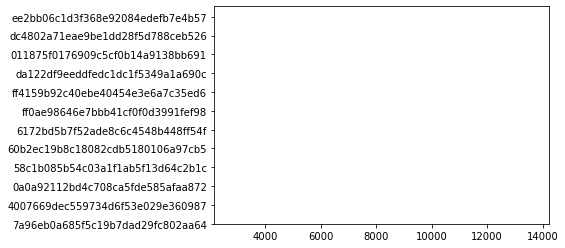

In [214]:
plt.bar(data, cust, color='green')
# plt.xlabel("Energy Source")
# plt.ylabel("Energy Output (GJ)")
# plt.title("Energy output from various fuel sources")

# plt.xticks(x_pos, x) 

plt.show()

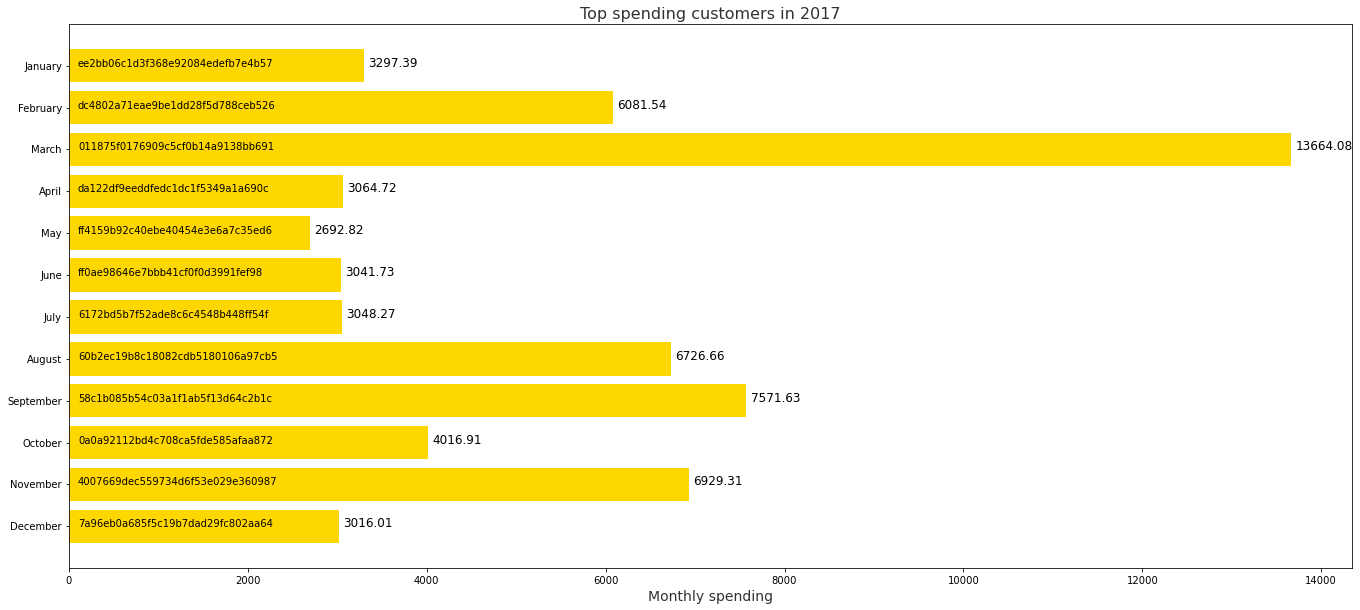

In [221]:
import numpy as np
height = data
bars = months

y_pos = np.arange(len(height))
 
#Figsize
plt.figure(figsize=(23,10))
 
# Create bars
plt.barh(y_pos, height, color = 'gold')
  
# Create names on the x-axis
plt.yticks(y_pos, bars, va="center")
 
plt.xlabel('Monthly spending', fontsize=14, color='#323232')
plt.title('Top spending customers in ' + str(last_year), fontsize=16, color='#323232')
# add_value_label(data, leg)
for i in range(len(cust)):
    plt.text(100, i, cust[i], color = "black", fontsize = 10)
    plt.text(data[i] + 50, i, data[i], color = "black", fontsize = 12)
 
# Show graphic
plt.show()

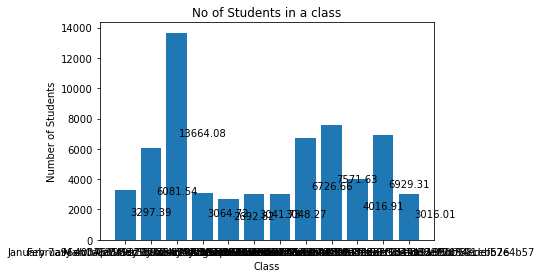

<Figure size 1440x720 with 0 Axes>

In [157]:
import matplotlib.pyplot as plt

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")

no_of_students=data
class_number=leg
y_pos = np.arange(len(height))
plt.bar(class_number,no_of_students)
add_value_label(class_number,no_of_students)
plt.title("No of Students in a class")
plt.xlabel("Class")
plt.ylabel("Number of Students")
plt.figure(figsize=(20,10))
plt.show()

TypeError: set_ticks() got an unexpected keyword argument 'labels'

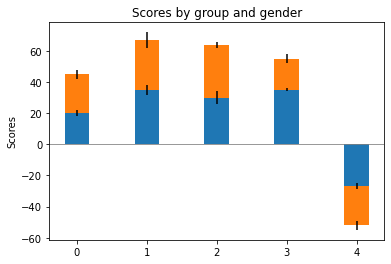

In [158]:
import matplotlib.pyplot as plt
import numpy as np


N = 5
menMeans = (20, 35, 30, 35, -27)
womenMeans = (25, 32, 34, 20, -25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(ind, menMeans, width, yerr=menStd, label='Men')
p2 = ax.bar(ind, womenMeans, width,
            bottom=menMeans, yerr=womenStd, label='Women')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, labels=['G1', 'G2', 'G3', 'G4', 'G5'])
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p2)

plt.show()

In [239]:
d = orders_df.groupBy(year("order_approved_at"), month("order_approved_at")).agg(count(year("order_approved_at")))

22/08/19 05:59:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 36982960 ms exceeds timeout 120000 ms
22/08/19 05:59:22 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:996)
	at org.apache.spark.

In [236]:
d.show()

+-----------------------+------------------------+------------------------------+
|year(order_approved_at)|month(order_approved_at)|count(year(order_approved_at))|
+-----------------------+------------------------+------------------------------+
|                   2017|                       3|                          2689|
|                   2017|                       8|                          4348|
|                   2017|                      10|                          4590|
|                   2018|                       1|                          7187|
|                   2018|                       3|                          7288|
|                   null|                    null|                             0|
|                   2018|                       8|                          6620|
|                   2017|                       7|                          3974|
|                   2016|                       9|                             1|
|               